In [1]:
import glob
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D

SEED = 2017

Using TensorFlow backend.


In [2]:
# Data can be downloaded at https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

In [3]:
# Specify data directory and extract all file names for both classes
DATA_DIR = '../Data/PetImages/'
cats = glob.glob(DATA_DIR + "Cat/*.jpg")
dogs = glob.glob(DATA_DIR + "Dog/*.jpg")

print('#Cats: {}, #Dogs: {}'.format(len(cats), len(dogs)))
# #Cats: 12500, #Dogs: 12500

#Cats: 12500, #Dogs: 12500


In [4]:
dogs_train, dogs_val, cats_train, cats_val = train_test_split(dogs, cats, test_size=0.2, random_state=SEED)

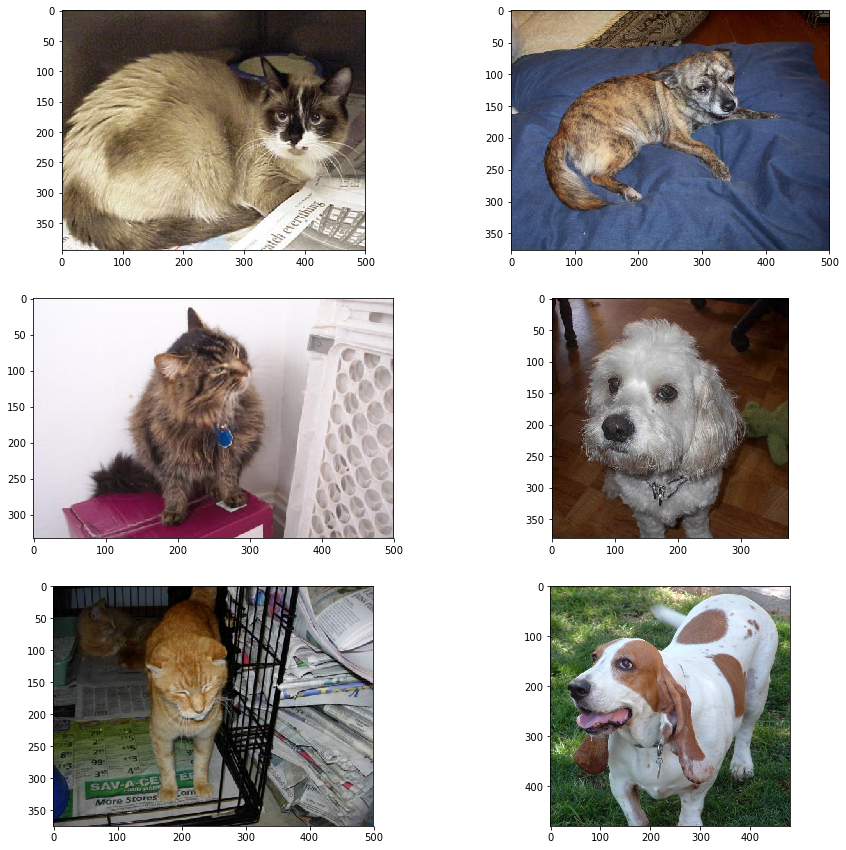

In [5]:
n_examples = 3
plt.figure(figsize=(15, 15))
i = 1
for _ in range(n_examples):
    image_cat = cats_train[np.random.randint(len(cats_train))]
    img_cat = cv2.imread(image_cat)
    img_cat = cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 2, i)
    _ = plt.imshow(img_cat)
    i += 1
    image_dog = dogs_train[np.random.randint(len(dogs_train))]
    img_dog = cv2.imread(image_dog)
    img_dog = cv2.cvtColor(img_dog, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 2, i)
    i += 1
    _ = plt.imshow(img_dog)
plt.show()

In [6]:
def batchgen(cats, dogs, batch_size, img_size=50):
    # Create empty numpy arrays
    batch_images = np.zeros((batch_size, img_size, img_size, 3))
    batch_label = np.zeros(batch_size)

    # Custom batch generator 
    while 1:
        n = 0
        while n < batch_size:
            # Randomly pick a dog or cat image
            if np.random.randint(2) == 1:
                i = np.random.randint(len(dogs))
                img = cv2.imread(dogs[i])
                if img is None:
                    break
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # The images have different dimensions, we resize all to 100x100
                img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
                y = 1

            else:
                i = np.random.randint(len(cats))
                img = cv2.imread(cats[i])
                if img is None:
                    break
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
                y = 0
        
            batch_images[n] = img
            batch_label[n] = y
            n+=1
        yield batch_images, batch_label

In [7]:
def create_model(stride=1, padding='same', img_size=100):
    # Define architecture
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.) - 0.5, input_shape=(img_size, img_size, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding=padding, strides=stride))
    model.add(Conv2D(32, (3, 3), activation='relu', padding=padding, strides=stride))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), activation='relu', padding=padding, strides=stride))
    model.add(Conv2D(64, (3, 3), activation='relu', padding=padding, strides=stride))
    
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
    
    return model

In [8]:
img_size = 100

models = []
for stride in [1, 2]:
    for padding in ['same', 'valid']:
        model = create_model(stride, padding, img_size)
        pars = model.count_params()
        models.append(dict({'setting': '{}_{}'.format(stride, padding), 
                'model': model,
                'parameters': pars
                }))

In [9]:
models[0]['model'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
__________

In [10]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', patience=5)]

In [11]:
batch_size = 512
n_epochs = 500
validation_steps = round((len(dogs_val)+len(cats_val))/batch_size)
steps_per_epoch = round((len(dogs_train)+len(cats_train))/batch_size)

train_generator = batchgen(dogs_train, cats_train, batch_size, img_size)
val_generator = batchgen(dogs_val, cats_val, batch_size, img_size)

history = []
for i in range(len(models)):
    print(models[i])
    history.append(
        models[i]['model'].
        fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=n_epochs, 
                            validation_data=val_generator, validation_steps=validation_steps,
                            callbacks=callbacks
                           )
    )

{'setting': '1_same', 'model': <keras.models.Sequential object at 0x7fece9877048>, 'parameters': 10305697}
Epoch 1/500
39/39 [==============================] - 77s - loss: 1.0154 - binary_accuracy: 0.4992 - val_loss: 0.6921 - val_binary_accuracy: 0.2928
Epoch 2/500
39/39 [==============================] - 80s - loss: 0.6825 - binary_accuracy: 0.5667 - val_loss: 0.6753 - val_binary_accuracy: 0.5758
Epoch 3/500
39/39 [==============================] - 54s - loss: 0.6811 - binary_accuracy: 0.5708 - val_loss: 0.6833 - val_binary_accuracy: 0.5592
Epoch 4/500
39/39 [==============================] - 67s - loss: 0.6742 - binary_accuracy: 0.5886 - val_loss: 0.6649 - val_binary_accuracy: 0.6379
Epoch 5/500
39/39 [==============================] - 58s - loss: 0.6702 - binary_accuracy: 0.6047 - val_loss: 0.6657 - val_binary_accuracy: 0.6109
Epoch 6/500
39/39 [==============================] - 72s - loss: 0.6691 - binary_accuracy: 0.6087 - val_loss: 0.6550 - val_binary_accuracy: 0.6436
Epoch 7/500

39/39 [==============================] - 59s - loss: 0.4910 - binary_accuracy: 0.7694 - val_loss: 0.4872 - val_binary_accuracy: 0.7600
Epoch 9/500
39/39 [==============================] - 65s - loss: 0.4852 - binary_accuracy: 0.7686 - val_loss: 0.4876 - val_binary_accuracy: 0.7662
Epoch 10/500
39/39 [==============================] - 62s - loss: 0.4576 - binary_accuracy: 0.7894 - val_loss: 0.4871 - val_binary_accuracy: 0.7654
Epoch 11/500
39/39 [==============================] - 64s - loss: 0.4479 - binary_accuracy: 0.7964 - val_loss: 0.4693 - val_binary_accuracy: 0.7641
Epoch 12/500
39/39 [==============================] - 57s - loss: 0.4253 - binary_accuracy: 0.8116 - val_loss: 0.4288 - val_binary_accuracy: 0.8031
Epoch 13/500
39/39 [==============================] - 62s - loss: 0.4172 - binary_accuracy: 0.8109 - val_loss: 0.4396 - val_binary_accuracy: 0.8203
Epoch 14/500
39/39 [==============================] - 66s - loss: 0.3924 - binary_accuracy: 0.8294 - val_loss: 0.4540 - val_bi

In [ ]:
for i in range(len(models)):
    plt.plot(range(len(history[i].history['val_binary_accuracy'])), history[i].history['val_binary_accuracy'], label=models[i]['setting'])
    print('Max accuracy model {}: {}'.format(models[i]['setting'], max(history[i].history['val_binary_accuracy'])))
plt.title('Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [17]:
for i in range(len(models)):
    plt.plot(range(len(history[i].history['val_binary_accuracy'])), history[i].history['val_binary_accuracy'], label=models[i]['setting'])
    print('Max accuracy model {}: {} (#parameters: {})'.format(models[i]['setting'], max(history[i].history['val_binary_accuracy']), models[i]['parameters']))

Max accuracy model 1_same: 0.8375 (#parameters: 10305697)
Max accuracy model 1_valid: 0.8466796875 (#parameters: 7995553)
Max accuracy model 2_same: 0.840625 (#parameters: 102561)
Max accuracy model 2_valid: 0.8298828125 (#parameters: 82081)
